In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit_machine_learning.neural_networks import EstimatorQNN,SamplerQNN
from IPython.display import clear_output
import matplotlib.pyplot as plt
import qiskit.quantum_info as qi
from qiskit.circuit import ParameterVector
from qiskit_algorithms.utils import algorithm_globals
import time as t
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2,RealAmplitudes
import numpy as np
from qiskit.primitives import Estimator
import pickle 

In [2]:
VQE_training = True
n_qubits=4
j_coupling=0.5
g_coupling=1.5
n_rep_VQEansatz=1

def callback_graph(x,name='loss'):
    #clear_output(wait=True)
    plt.title("Training curve")
    plt.xlabel("Iteration")
    plt.ylabel(name)
    plt.plot(range(len(x)), x,label='ground state energy')
    #plt.show()


In [5]:
def getGoundState(n_qubits=n_qubits,j_coupling=j_coupling,g_coupling=g_coupling,n_rep_VQEansatz=1,nSteps=200
                 ,learning_rate=1e-1):
    h_coupling=j_coupling*g
    qr_VQE = QuantumRegister(n_qubits)
    qc_VQE = QuantumCircuit(qr_VQE)
    ansatz_VQE =  RealAmplitudes(num_qubits=n_qubits,reps=n_rep_VQEansatz)
    qc_VQE.h(qr_VQE)
    qc_VQE.compose(ansatz_VQE, inplace=True)  
    
    observable = SparsePauliOp.from_list([("X"+"I"*(n_qubits-1) , h_coupling )])
    for i in np.arange(1,n_qubits,1):
        observable=observable + SparsePauliOp.from_list([("I"*(i)+"X"+"I"*(n_qubits-1-i) , -h_coupling )])
    for i in range(n_qubits-1):
        observable=observable + (SparsePauliOp.from_list([("I"*(i)+"ZZ"+"I"*(n_qubits-2-i) ,- j_coupling)]))
        
       
    qnn_VQE=EstimatorQNN(
        estimator=Estimator(options={"shots":1e10}),
        circuit=qc_VQE,
        weight_params=ansatz_VQE.parameters,
        observables=observable
        )

    eigenValues=np.linalg.eig(observable.to_matrix())[0]
    eigenValues.sort()

    groundEnergy=eigenValues[0]
    #print("ground state energy =", groundEnergy)
    
    init_weights=np.random.rand(qnn_VQE.num_weights)*2*np.pi
    weights=init_weights
    
    loss=[]
    for i in range(nSteps):
        vev=qnn_VQE.forward([], weights)[0][0]
        input_grad, weight_grad=qnn_VQE.backward([],weights)
        grad=weight_grad[0,0,:]
        weights=weights-learning_rate*grad
        loss.append(vev)

#         if i%1==0:

#             clear_output(wait=True)
#             plt.figure(1)
#             callback_graph(loss)
#             plt.plot(range(len(loss)),groundEnergy*np.ones(len(loss)),label='truth')
#             plt.legend()
#             #plt.yscale('log')
#             plt.show()

    return weights,vev,groundEnergy

Next, prepare a series of ground states and its labels based on the value of |g|

For |g|<1, two-fold degenerate ground state.

For |g|>1, non-degenerate ground state.

In [29]:
if VQE_training:#Obtaining ground state for |g|<1 
    nSteps=50
    lowGs=np.arange(0,1.0,0.05)
    highGs=np.arange(1.05,2.05,0.05)
    w_low=[]
    Egs_estimate_low=[]
    Egs_low=[]
    for g in lowGs:
        for i in range(10):
            weights,Egs_estimate,Egs=getGoundState(g_coupling=g,nSteps=nSteps,learning_rate=1e0)
            diff=abs(Egs_estimate-Egs)/abs(Egs)

            if diff< 0.015:
                break
                
        print("g = ",g," diff=",diff)
                
        w_low.append(weights)
        Egs_estimate_low.append(Egs_estimate)
        Egs_low.append(Egs)

    print("lowG finished")
    dict_low={"weights": w_low,"E_gs_estimate": Egs_estimate_low,
              "E_gs":Egs_low,"g":lowGs}
    with open('lowG_dict.pkl', 'wb') as f:
        pickle.dump(dict_low, f)


    w_high=[]
    Egs_estimate_high=[]
    Egs_high=[]
    for g in highGs:
        for i in range(10):
            weights,Egs_estimate,Egs=getGoundState(g_coupling=g,nSteps=nSteps)
            diff=abs(Egs_estimate-Egs)/abs(Egs)
            if diff< 0.015:
                break
        print("g = ",g," diff=",diff)
        w_high.append(weights)
        Egs_estimate_high.append(Egs_estimate)
        Egs_high.append(Egs)

    dict_high={"weights": w_high,"E_gs_estimate":Egs_estimate_high,
               "E_gs": Egs_high ,"g":highGs}
    with open('highG_dict.pkl', 'wb') as f:
        pickle.dump(dict_high, f)

g =  0.0  diff= 6.076409005591662e-10
g =  0.05  diff= 0.00010300534915192559
g =  0.1  diff= 0.001220320232442067
g =  0.15000000000000002  diff= 0.003904536249820186
g =  0.2  diff= 0.007115798062960532
g =  0.25  diff= 0.0011856659398320794
g =  0.30000000000000004  diff= 0.003651227119486306
g =  0.35000000000000003  diff= 0.0041026572993159306
g =  0.4  diff= 0.006646536379579114
g =  0.45  diff= 0.010396204520042291
g =  0.5  diff= 0.014558853946660679
g =  0.55  diff= 0.019403363209769434
g =  0.6000000000000001  diff= 0.021372697772222372
g =  0.65  diff= 0.01418372304094998
g =  0.7000000000000001  diff= 0.014161768334635323
g =  0.75  diff= 0.014310698222524627
g =  0.8  diff= 0.013439603503924629
g =  0.8500000000000001  diff= 0.009799647158533183
g =  0.9  diff= 0.011078496556386569
g =  0.9500000000000001  diff= 0.01000241712283155
lowG finished
g =  1.05  diff= 0.014314613343983935
g =  1.1  diff= 0.06713913543925024
g =  1.1500000000000001  diff= 0.06161430378047601
g = 

In [41]:
with open('lowG_dict.pkl', 'rb') as f:
    dict_low = pickle.load(f)

with open('highG_dict.pkl', 'rb') as f:
    dict_high = pickle.load(f)

In [31]:
n_layers=1
n_params=n_layers*1+n_qubits+1
weights = ParameterVector("weight", n_params)
params_index=0
qr = QuantumRegister(n_qubits)
qc = QuantumCircuit(qr)
qc.compose(RealAmplitudes(num_qubits=n_qubits,reps=n_rep_VQEansatz), inplace=True) 
qc.barrier()
for layer in range(n_layers):
    for i in np.arange(0,n_qubits-1,1):
        qc.rzz(weights[params_index],i,i+1)
    params_index += 1
qc.barrier()
#pooling layer:
for i in np.arange(0,int(n_qubits/2),1):
    qc.rz(weights[params_index],i*2)
    
params_index += 1

for i in np.arange(0,int(n_qubits/2),1):
    qc.rz(weights[params_index],i*2+1)
    qc.cx(2*i,2*i+1)
params_index += 1

for i in np.arange(0,int(n_qubits/2),1):
    qc.rz(-weights[params_index-2],i*2+1)
qc.barrier()

for i in np.arange(0,int(n_qubits/4),1):
    qc.rzz(weights[params_index],i*4+1,i*4+3)
qc.barrier()
params_index += 1

for i in np.arange(0,int(n_qubits/4),1):
    qc.rz(weights[params_index],i*4+1)
params_index += 1

for i in np.arange(0,int(n_qubits/4),1):
    qc.rz(weights[params_index],i*4+3)
    qc.cx(i*4+1,i*4+3)
params_index += 1

for i in np.arange(0,int(n_qubits/4),1):
    qc.rz(-weights[params_index-2],i*4+3)
qc.barrier()

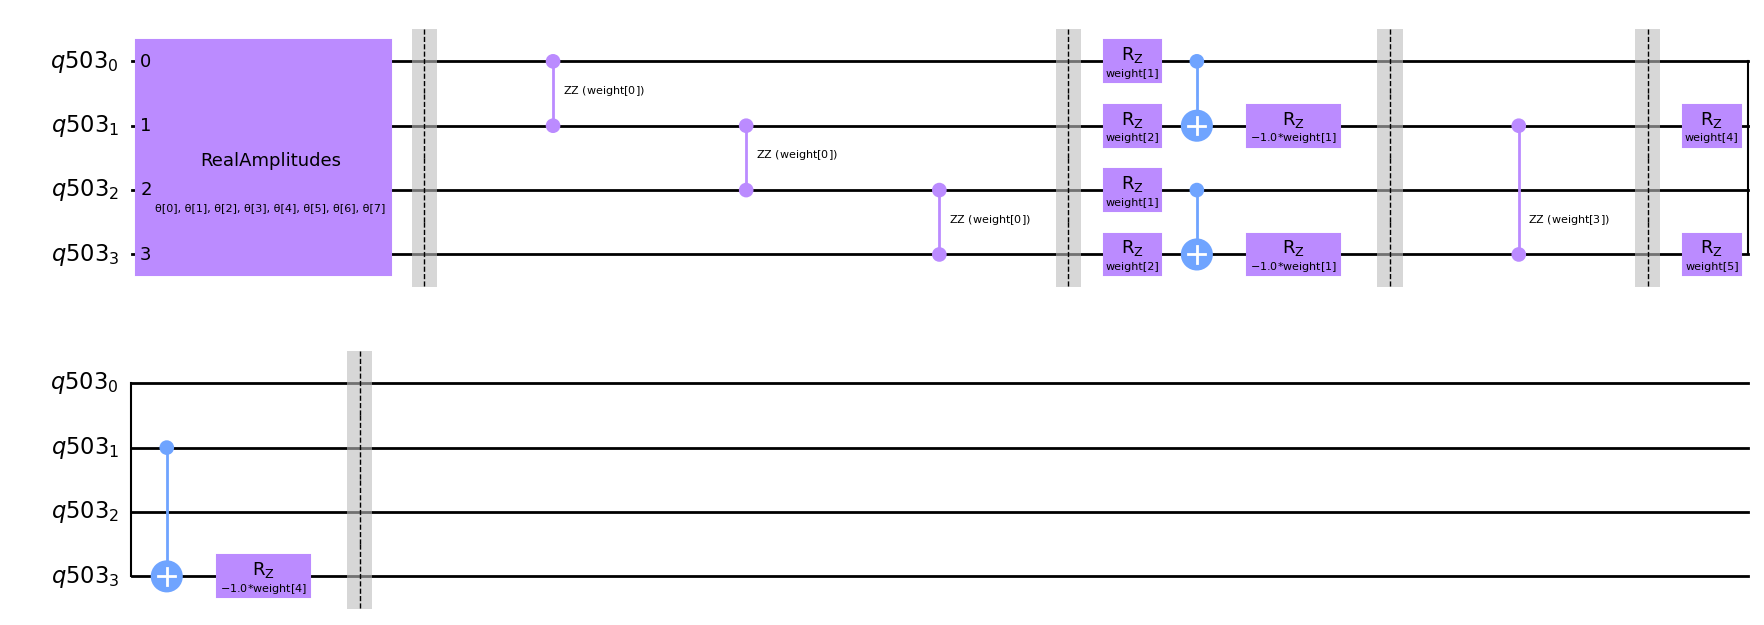

In [32]:
qc.draw('mpl')

In [33]:
qc.num_parameters

14

In [34]:
estimator = Estimator()
ob = SparsePauliOp.from_list([("I"*(n_qubits-1)+"Z" , 1 )])

In [35]:
params=2*np.pi*np.random.rand(qc.num_parameters)

In [36]:
job=estimator.run(circuits=[qc], observables=[ob], parameter_values=[params])

In [37]:
job.result()

EstimatorResult(values=array([0.07340149]), metadata=[{}])

In [42]:
np.concatenate([dict_low['weights'][0]+2*np.pi*np.random.rand(qc.num_parameters)

ValueError: operands could not be broadcast together with shapes (8,) (14,) 